# Peer-graded Assigement:

## Applied Data Science Capstone by IBM/Coursera 

## The Battle of Neighborhoods

## Chicago: Is it the Safest City to Live in the U.S.?

## 1.	Introduction

<b>Background </b>

Chicago is one of biggest cities in the USA. According to the United States Census Bureau estimates as of 2018, Chicago is the third-largest city by population. It is also a major world financial center and the second-largest central business district in the United States. Nonetheless, Chicago is also among the ten largest metropolitan areas in the US by crime rate. According to Wikipedia, the city's overall crime rate is higher than the US average. 

<b>Problem</b>

The question to be discussed is whether there is a relationship or dependency between the crime rate and the venues in the city. Arguably, the crime rate determines the number of venues in the city. Here we will test this hypothesis. Moreover, these two indicators inevitably have some bearing on the housing sale price.

<b>Interest</b>

This project is tailored towards a variety of audiences, ranging from researchers and sociologists to anyone, who might be in a search for a new home or is interested in exploring new community areas in Chicago. For instance, researches, studying the social dependencies in the society; real estate agents and people, interested in real estate market, as the current topic deals with the relationship between crime rate and availablity of venues for meetings and other social and cultural gatherings.


## 2. Data

   
In the 1920s, the city has been subdivided into 77  distinct community areas. In order to find the areas with the biggest crime activity, the Data Portal of the city of Chicago provides a detailed information pertaining to the crimes since 2001 (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2). However, since we would like to get a more up-to-date perspective on the matter, we will utilize the date since 2016.
Chicago Data Portal will also furnish us with details for the community areas, including the respective coordinates. This will help us create a choropleth map of the crime data per area. 
From FOURSQUARE website, and more precisely by using its API call, we will obtain information about the current venues in these areas. The idea is to check whether the crime activity, accumulated over a period of three and a half years shapes the venues in the current daily life. 


## 3. Methodology

<b>Data collection</b>

We collected all the necessary data from Chicago Data Portal, i.e. crime data as of 2001 and coordinates of the community areas.  The dataset was cleaned and narrowed to include only crime data for each area since 2016. The missing data was dropped, since it would not had any affect on the results (only 2 out of more than 900,000 values were missing). Respectively, Numpy and Pandas packages were employed to manipulate the datasets.

<b>Crime Map of Chicago</b>

Geopy.geocoders.Nominatim package was used the obtain the coordinates of Chicago, while a GeoJSON file from Chicago Data Portal provided the necessary data to define the different areas. A choropleth map of Chicago was created to visualize how the crime rate varies across the community areas. In order to do that, we used Python Folium library.

<b>Foursquare </b>

The usage of Foursquare API was a prerequisite for this project. For this reason it was used to explore the venues in the community areas of Chicago. We limited our request to 100 venues per area and wrote all the results in a dataframe. Foursquare returned 1,893 venues. 
Afterwards, we analyzed all venue category for each community area and created a new dataframe, containing information about the top 10 most common venues in each area.
As there are some common venue categories in the community areas, we need to cluster them using the K-Means clustering algorithm and the package Scikit-learn. First, we had to determine how many clusters we should use. 10 different values of K (i.e. from 1 to 10) were tried and "elbow" method helped to find the optimal k, which in this case turned to be 4. 
For visualization of the clusters map we used again Folium package. For the charts throughout  this project Matplitlib package is utilized. 


In [1]:
import pandas as pd
import numpy as np 
import folium
from folium import plugins

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim

import urllib.request, json 

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans   #import k-means from clustering stage

import os
import webbrowser

print('Libraries imported!')

Libraries imported!


## 4.  Download and Explore Dataset

In [2]:
#!wget -O Crimes_2001_to_present.csv https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv
df = pd.read_csv('Crimes_2001_to_present.csv')

df.head()

ID Case Number                    Date                Block  IUCR  \
0  11815586    JC417861  09/02/2019 11:58:00 PM    107XX S EWING AVE  0860   
1  11815543    JC417855  09/02/2019 11:51:00 PM   039XX W GLADYS AVE  2825   
2  11815515    JC417849  09/02/2019 11:50:00 PM      003XX W 23RD PL  033A   
3  11815537    JC417846  09/02/2019 11:44:00 PM  029XX N ASHLAND AVE  0860   
4  11819270    JC422431  09/02/2019 11:40:00 PM      022XX E 70TH ST  1320   

      Primary Type              Description           Location Description  \
0            THEFT             RETAIL THEFT              CONVENIENCE STORE   
1    OTHER OFFENSE  HARASSMENT BY TELEPHONE                          ALLEY   
2          ROBBERY   ATTEMPT: ARMED-HANDGUN  RESIDENTIAL YARD (FRONT/BACK)   
3            THEFT             RETAIL THEFT             GROCERY FOOD STORE   
4  CRIMINAL DAMAGE               TO VEHICLE                         STREET   

   Arrest  Domestic  ...  Longitude                       Location  \
0   False     False  ... -87.535280  (41.699927519, -87.535280094)   
1   False      True  ... -87.723958  (41.876198927, -87.723957984)   
2   False     False  ... -87.635288  (41.850021724, -87.635288097)   
3    True     False  ... -87.668504  (41.935432921, -87.668504341)   
4   False     False  ...        NaN                            NaN   

   Historical Wards 2003-2015  Zip Codes Community Areas  Census Tracts  \
0                        47.0    21202.0            49.0          715.0   
1                        11.0    21572.0            27.0          736.0   
2                         8.0    21194.0            35.0            3.0   
3                        16.0     4449.0            57.0          712.0   
4                         NaN        NaN             NaN            NaN   

   Wards  Boundaries - ZIP Codes Police Districts  Police Beats  
0   47.0                    25.0             19.0         247.0  
1   23.0                    30.0             16.0         142.0  
2   26.0                    40.0             23.0         157.0  
3   40.0                    22.0              5.0         173.0  
4    NaN                     NaN              NaN           NaN  

[5 rows x 30 columns]

####  Create a dataframe 

In [3]:
data = df[['Community Area','Year']]
data.drop(data[data['Year'] < 2016].index, inplace = True) 

data.head(5)
#list(data)

C:\Users\TONI\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Community Area  Year
0            52.0  2019
1            26.0  2019
2            34.0  2019
3             6.0  2019
4            43.0  2019

#### Clean the dataframe

In [4]:
data.isnull().sum()

Community Area    2
Year              0
dtype: int64

We will drop the rows with missing values and rename a column.

In [5]:
# drop the rows with missing values and rename a column
data.dropna(how='any', inplace=True) 
data.rename(columns={'Community Area':'Area_Number'}, inplace=True)
data.head()

C:\Users\TONI\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\TONI\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Area_Number  Year
0         52.0  2019
1         26.0  2019
2         34.0  2019
3          6.0  2019
4         43.0  2019

In [6]:
data.shape

(978913, 2)

We need to get rid of decimal value so it can be match with the geojsom file and be converted to choropleth map.
We will remove the decimal point values by converting the column to int type and then back to string type.

In [7]:
CrimeData = pd.DataFrame(data['Area_Number'].value_counts().astype(float))

CrimeData.to_json('Chicago_Crime_Map.json')

CrimeData = CrimeData.reset_index()
CrimeData.columns = ['Area_Number', 'Crime_Count']

# convert float to int then to string
CrimeData['Area_Number'] = CrimeData['Area_Number'].astype('int').astype('str')

CrimeData.head()

Area_Number  Crime_Count
0          25      57211.0
1           8      44399.0
2          32      37822.0
3          28      34040.0
4          29      33249.0

## 5. Crime Map of Chicago

Let's find geograpical coordinate of Chicago. We will use *geopy* library to get the latitude and longitude values of Chicago.

In [8]:
address = 'Chicago'

geolocator = Nominatim(user_agent="chicago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


Now, let'screate a plain Chicago map.

In [9]:
# geojson file
chicago_geo = 'Boundaries_Community_Areas.geojson'

# create a plain Chicago map
chicago_map = folium.Map(
    location=(41.8755616, -87.6244212),
    zoom_start = 12
)
            
# display map
chicago_map

In [10]:
threshold_scale = np.linspace(CrimeData['Crime_Count'].min(),
                              CrimeData['Crime_Count'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration


chicago_map.choropleth(
    geo_data=chicago_geo,
    data=CrimeData,
    columns=['Area_Number', 'Crime_Count'],
    key_on='feature.properties.area_numbe',
    threshold_scale=threshold_scale,
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    #hover_name="Crime_Count",
    legend_name='Number of crimes per community area in Chicago',
    reset=True
)

chicago_map

#### Getting the geographical coordinates of each community area

In [11]:
#!wget -O Chicago_Areas_Coordinates.csv https://github.com/Toneva/Coursera_Capstone/blob/master/Chicago_Areas_Coordinates.csv
Chicago_Areas_Coordinates = pd.read_csv('Chicago_Areas_Coordinates.csv')

Chicago_Areas_Coordinates.head()

Community_Area  Community_Name   Latitude  Longitude
0               1     Rogers Park  42.009120 -87.668648
1               2      West Ridge  41.999316 -87.692394
2               3          Uptown  41.966222 -87.658792
3               4  Lincoln Square  41.968844 -87.685397
4               5    North Center  41.950503 -87.681029

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods 

## 6. Explore Community Areas in Chicago

### Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = 'QNCCMYSOVXIWQ2VHVUX5USFECOYQYF0PVM4ANKUVA1PLHVPQ' # your Foursquare ID
CLIENT_SECRET = 'E32FIMBU0DTIDMOW1OHY5HTEE11P1MA1HQWCGBI3XDDOGXCY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QNCCMYSOVXIWQ2VHVUX5USFECOYQYF0PVM4ANKUVA1PLHVPQ
CLIENT_SECRET:E32FIMBU0DTIDMOW1OHY5HTEE11P1MA1HQWCGBI3XDDOGXCY


Now, let's get the top 100 venues that are the community areas (within a radius of 500 meters).
First, let's create the GET request URL. Name your URL url.

Let's create a function to repeat the  process to all the areas in Chicago.

In [13]:
import requests # library to handle requests


In [14]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community_Name', 
                  'Community_Latitude', 
                  'Community_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

Let's run the above function on each area and create a new dataframe called *chicago_venues*.

In [15]:
chicago_venues = getNearbyVenues(names=Chicago_Areas_Coordinates['Community_Name'],
                                 latitudes=Chicago_Areas_Coordinates['Latitude'],
                                 longitudes=Chicago_Areas_Coordinates['Longitude']
                                )


Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt Park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
Mckinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Heights
Mount Greenwood
Morgan Park
Ohare
Edgewater


#### Let's check the size of the resulting dataframe

In [16]:
print(chicago_venues.shape)
chicago_venues.head()

(1893, 7)


Community_Name  Community_Latitude  Community_Longitude  \
0    Rogers Park            42.00912           -87.668648   
1    Rogers Park            42.00912           -87.668648   
2    Rogers Park            42.00912           -87.668648   
3    Rogers Park            42.00912           -87.668648   
4    Rogers Park            42.00912           -87.668648   

                    Venue  Venue_Latitude  Venue_Longitude  Venue_Category  
0      Morse Fresh Market       42.008087       -87.667041   Grocery Store  
1          The Common Cup       42.007797       -87.667901     Coffee Shop  
2  Glenwood Sunday Market       42.008525       -87.666251  Farmers Market  
3            The Glenwood       42.008502       -87.666273             Bar  
4      Rogers Park Social       42.007360       -87.666265             Bar

Let's check how many venues were returned for each neighborhood

In [17]:
chicago_venues.groupby('Community_Name').count()

Community_Latitude  Community_Longitude  Venue  \
Community_Name                                                           
Albany Park                             26                   26     26   
Archer Heights                          23                   23     23   
Armour Square                           16                   16     16   
Ashburn                                 12                   12     12   
Auburn Gresham                          10                   10     10   
Austin                                   9                    9      9   
Avalon Park                             18                   18     18   
Avondale                                33                   33     33   
Belmont Cragin                          10                   10     10   
Bridgeport                              53                   53     53   
Brighton Park                            8                    8      8   
Burnside                                 7                    7      7   
Calumet Heights                          4                    4      4   
Chatham                                  9                    9      9   
Chicago Lawn                            16                   16     16   
Clearing                                17                   17     17   
Douglas                                 37                   37     37   
Dunning                                 11                   11     11   
East Garfield Park                       8                    8      8   
East Side                               12                   12     12   
Edgewater                               50                   50     50   
Edison Park                             29                   29     29   
Englewood                               10                   10     10   
Forest Glen                              4                    4      4   
Fuller Park                              4                    4      4   
Gage Park                               14                   14     14   
Garfield Ridge                          18                   18     18   
Grand Boulevard                         16                   16     16   
Greater Grand Crossing                   4                    4      4   
Hegewisch                               12                   12     12   
...                                    ...                  ...    ...   
Near North Side                        100                  100    100   
Near South Side                         42                   42     42   
Near West Side                          37                   37     37   
New City                                19                   19     19   
North Center                            38                   38     38   
North Lawndale                           4                    4      4   
North Park                              17                   17     17   
Norwood Park                            13                   13     13   
Oakland                                 13                   13     13   
Ohare                                    4                    4      4   
Portage Park                            21                   21     21   
Pullman                                  5                    5      5   
Riverdale                                1                    1      1   
Rogers Park                             33                   33     33   
Roseland                                 5                    5      5   
South Chicago                            8                    8      8   
South Deering                            1                    1      1   
South Lawndale                          21                   21     21   
South Shore                             28                   28     28   
Uptown                                  83                   83     83   
Washington Heights                       5                    5      5   
Washington Park             

### Analyze Each Community Area

In [18]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue_Category']], prefix="", prefix_sep="")

# add community column back to dataframe
chicago_onehot['Community_Name'] = chicago_venues['Community_Name'] 

# move community column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

Community_Name  ATM  Afghan Restaurant  African Restaurant  Airport Lounge  \
0    Rogers Park    0                  0                   0               0   
1    Rogers Park    0                  0                   0               0   
2    Rogers Park    0                  0                   0               0   
3    Rogers Park    0                  0                   0               0   
4    Rogers Park    0                  0                   0               0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                    0             0       0                 0   
1                    0             0       0                 0   
2                    0             0       0                 0   
3                    0             0       0                 0   
4                    0             0       0                 0   

   Argentinian Restaurant  ...  Vegetarian / Vegan Restaurant  \
0                       0  ...                              0   
1                       0  ...                              0   
2                       0  ...                              0   
3                       0  ...                              0   
4                       0  ...                              0   

   Video Game Store  Video Store  Vietnamese Restaurant  Weight Loss Center  \
0                 0            0                      0                   0   
1                 0            0                      0                   0   
2                 0            0                      0                   0   
3                 0            0                      0                   0   
4                 0            0                      0                   0   

   Whisky Bar  Wine Bar  Wings Joint  Women's Store  Yoga Studio  
0           0         0            0              0            0  
1           0         0            0              0            0  
2           0         0            0              0            0  
3           0         0            0              0            0  
4           0         0            0              0            0  

[5 rows x 260 columns]

In [19]:
# let's examine the new dataframe size.
chicago_onehot.shape

(1893, 260)

#### Next, let's group rows by community area and by taking the mean of the frequency of occurrence of each category

In [20]:
chicago_grouped = chicago_onehot.groupby('Community_Name').mean().reset_index()
chicago_grouped

Community_Name       ATM  Afghan Restaurant  African Restaurant  \
0              Albany Park  0.000000           0.000000            0.000000   
1           Archer Heights  0.000000           0.000000            0.000000   
2            Armour Square  0.000000           0.000000            0.000000   
3                  Ashburn  0.000000           0.000000            0.000000   
4           Auburn Gresham  0.000000           0.000000            0.000000   
5                   Austin  0.000000           0.000000            0.000000   
6              Avalon Park  0.000000           0.000000            0.000000   
7                 Avondale  0.030303           0.000000            0.000000   
8           Belmont Cragin  0.000000           0.000000            0.000000   
9               Bridgeport  0.000000           0.000000            0.000000   
10           Brighton Park  0.000000           0.000000            0.000000   
11                Burnside  0.000000           0.000000            0.000000   
12         Calumet Heights  0.000000           0.000000            0.000000   
13                 Chatham  0.000000           0.000000            0.000000   
14            Chicago Lawn  0.000000           0.000000            0.000000   
15                Clearing  0.000000           0.000000            0.000000   
16                 Douglas  0.000000           0.000000            0.027027   
17                 Dunning  0.000000           0.000000            0.000000   
18      East Garfield Park  0.000000           0.000000            0.000000   
19               East Side  0.083333           0.000000            0.000000   
20               Edgewater  0.000000           0.000000            0.000000   
21             Edison Park  0.000000           0.000000            0.000000   
22               Englewood  0.200000           0.000000            0.000000   
23             Forest Glen  0.000000           0.000000            0.000000   
24             Fuller Park  0.000000           0.000000            0.000000   
25               Gage Park  0.000000           0.000000            0.000000   
26          Garfield Ridge  0.000000           0.000000            0.000000   
27         Grand Boulevard  0.000000           0.000000            0.000000   
28  Greater Grand Crossing  0.000000           0.000000            0.000000   
29               Hegewisch  0.000000           0.000000            0.000000   
..                     ...       ...                ...                 ...   
46         Near North Side  0.000000           0.000000            0.000000   
47         Near South Side  0.000000           0.000000            0.000000   
48          Near West Side  0.000000           0.000000            0.000000   
49                New City  0.000000           0.000000            0.000000   
50            North Center  0.000000           0.000000            0.000000   
51          North Lawndale  0.000000           0.000000            0.000000   
52              North Park  0.000000           0.000000            0.000000   
53            Norwood Park  0.000000           0.000000            0.000000   
54                 Oakland  0.000000           0.000000            0.000000   
55                   Ohare  0.000000           0.000000            0.000000   
56            Portage Park  0.000000           0.000000            0.000000   
57                 Pullman  0.000000           0.000000            0.000000   
58               Riverdale  0.000000           0.000000            0.000000   
59             Rogers Park  0.000000           0.000000            0.000000   
60                Roseland  0.000000           0.000000            0.000000   
61           South Chicago  0.000000           0.000000            0.000000   
62           South Deering  0.000000           0.000000            0.000000   
63          South Lawndale  0.000000           0.000000            0.000000   
64             South Shore  0.000000           0.000000       

In [21]:
# Let's confirm the new size
chicago_grouped.shape

(76, 260)

#### Let's print each community area along with the top 5 most common venues

In [22]:
num_top_venues = 5

for hood in chicago_grouped['Community_Name']:
    print("----"+hood+"----")
    temp = chicago_grouped[chicago_grouped['Community_Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albany Park----
                venue  freq
0  Mexican Restaurant  0.31
1              Bakery  0.08
2    Sushi Restaurant  0.08
3       Grocery Store  0.04
4       Train Station  0.04


----Archer Heights----
                venue  freq
0  Mexican Restaurant  0.13
1                Bank  0.09
2      Discount Store  0.09
3      Sandwich Place  0.09
4         Pizza Place  0.09


----Armour Square----
                venue  freq
0  Chinese Restaurant  0.38
1      Cosmetics Shop  0.06
2   Mobile Phone Shop  0.06
3    Business Service  0.06
4  Light Rail Station  0.06


----Ashburn----
                        venue  freq
0                 Pizza Place  0.17
1  Construction & Landscaping  0.08
2               Train Station  0.08
3                        Park  0.08
4        Fast Food Restaurant  0.08


----Auburn Gresham----
            venue  freq
0        Pharmacy   0.2
1          Bakery   0.1
2     Video Store   0.1
3       BBQ Joint   0.1
4  Discount Store   0.1


----Austin----
       

                    venue  freq
0             Pizza Place  0.13
1  Furniture / Home Store  0.13
2         Automotive Shop  0.13
3       Martial Arts Dojo  0.07
4             Bus Station  0.07


----Morgan Park----
               venue  freq
0  Convenience Store  0.17
1  Currency Exchange  0.17
2          BBQ Joint  0.17
3               Park  0.17
4              Track  0.17


----Mount Greenwood----
                venue  freq
0         Dry Cleaner   0.2
1           Pet Store   0.2
2           Gift Shop   0.2
3  Mexican Restaurant   0.2
4                 Gym   0.2


----Near North Side----
                 venue  freq
0                Hotel  0.07
1  American Restaurant  0.06
2           Steakhouse  0.06
3        Women's Store  0.05
4          Coffee Shop  0.05


----Near South Side----
                venue  freq
0    Football Stadium  0.12
1  Athletics & Sports  0.10
2                 Bar  0.05
3                Park  0.05
4       Historic Site  0.05


----Near West Side----
           

#### Let's put that  info into a *pandas* dataframe

In [23]:
# Let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each area.

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Community_Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
areas_venues_sorted = pd.DataFrame(columns=columns)
areas_venues_sorted['Community_Name'] = chicago_grouped['Community_Name']

for ind in np.arange(chicago_grouped.shape[0]):
    areas_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

areas_venues_sorted.head()

Community_Name 1st Most Common Venue 2nd Most Common Venue  \
0     Albany Park    Mexican Restaurant                Bakery   
1  Archer Heights    Mexican Restaurant        Discount Store   
2   Armour Square    Chinese Restaurant           Pizza Place   
3         Ashburn           Pizza Place         Train Station   
4  Auburn Gresham              Pharmacy             BBQ Joint   

        3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Sushi Restaurant         Hot Dog Joint                  Park   
1                        Bank           Pizza Place        Sandwich Place   
2               Event Service      Business Service     Mobile Phone Shop   
3  Construction & Landscaping        Cosmetics Shop                  Park   
4        Fast Food Restaurant        Cosmetics Shop        Discount Store   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0     Korean Restaurant           Bus Station            Taco Place   
1    Seafood Restaurant                Bakery     Mobile Phone Shop   
2    Mexican Restaurant            Print Shop        Breakfast Spot   
3  Fast Food Restaurant          Liquor Store                  Food   
4           Video Store                Bakery    Dim Sum Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0  Fast Food Restaurant                  Diner  
1           Bus Station                  Hotel  
2    Light Rail Station                   Park  
3    Italian Restaurant        Automotive Shop  
4    Seafood Restaurant     English Restaurant

## 7. Cluster Community Areas in Chicago

As there are some common venue categories in the areas, we need to cluster the community areas, using the K-Means clustering algorithm. First, we need to determine how many clusters we need to use. The "elbow" method helps to find the optimal k.

In [25]:
from scipy.spatial.distance import cdist

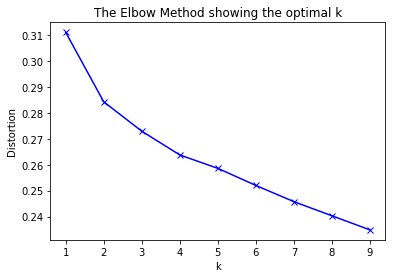

In [26]:
# try with 10 different values of k to find the best one
Ks = 10
distortions = []

chicago_grouped_clustering = chicago_grouped.drop('Community_Name', 1)

for k in range(1, Ks):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(chicago_grouped_clustering)

    # find the distortion w.r.t each k
    distortions.append(
        sum(np.min(cdist(chicago_grouped_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1))
        / chicago_grouped_clustering.shape[0]
    )

plt.plot(range(1, Ks), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


Run k-means to cluster the neighborhood into 4 clusters.

In [27]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each community area.

In [28]:
# add clustering labels
areas_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chicago_merged = Chicago_Areas_Coordinates

# merge Chicago_Areas_Coordinates with areas_venues_sorted to add latitude/longitude for each area
chicago_merged = chicago_merged.join(areas_venues_sorted.set_index('Community_Name'), on='Community_Name')

chicago_merged = chicago_merged.fillna(0)
chicago_merged['Cluster Labels'] = chicago_merged['Cluster Labels'].astype('int64')

chicago_merged.head() # check the last columns!

Community_Area  Community_Name   Latitude  Longitude  Cluster Labels  \
0               1     Rogers Park  42.009120 -87.668648               2   
1               2      West Ridge  41.999316 -87.692394               2   
2               3          Uptown  41.966222 -87.658792               2   
3               4  Lincoln Square  41.968844 -87.685397               2   
4               5    North Center  41.950503 -87.681029               2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0   American Restaurant    Mexican Restaurant           Pizza Place   
1     Indian Restaurant  Pakistani Restaurant         Grocery Store   
2           Pizza Place           Coffee Shop    Mexican Restaurant   
3                   Bar                  Café        Sandwich Place   
4                   Pub   Arts & Crafts Store              Boutique   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Theater                   Bar    Chinese Restaurant   
1          Dessert Shop                   Bar            Donut Shop   
2    Chinese Restaurant         Grocery Store        Sandwich Place   
3       Thai Restaurant    Chinese Restaurant      Sushi Restaurant   
4           Coffee Shop     Mobile Phone Shop           Pizza Place   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Bakery            Donut Shop        Sandwich Place   
1             Juice Bar      Football Stadium        Clothing Store   
2                   Bar      Sushi Restaurant        Discount Store   
3          Gourmet Shop                   Gym           Coffee Shop   
4                   Bar           Yoga Studio           Bus Station   

    10th Most Common Venue  
0           Breakfast Spot  
1  Fruit & Vegetable Store  
2        Mobile Phone Shop  
3         Toy / Game Store  
4           Sandwich Place

Finally, let's visualize the resulting clusters

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Community_Name'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now we want to create a choropleth map of the crime rate, combined with the map of clusters.

In [30]:
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Community_Name'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(chicago_map)
       
chicago_map

It is evident from the map above that community areas with higher crime rate enjoy similar venues for events and gathering as areas with lower crime rate. Seemingly there is no relationship between them. 

Let's perform some additional exploratory data analysis to verify the this conclusion.

## 8. Exploratory Data Analysis

#### Let's create a dataframe, containing all summary data for each community area of Chicago

Let's gather all the data per a community area in a single dataframe. First, we gather the information of the number of venues per area. Next we add the area code and then, we add the crime data for each area.

In [31]:
# number of venues per area
chicago_data = chicago_venues.groupby('Community_Name').count().reset_index()

# merge the above dataframe with Chicago_Areas_Coordinates to assign Area_Number
chicago_data_merged = pd.merge(Chicago_Areas_Coordinates, chicago_data, on=['Community_Name'])
chicago_data_merged.rename(columns={'Community_Area':'Area_Number'}, inplace=True)

# converting the columns in CrimeDate to int type to facilitate the merge function
CrimeData[['Area_Number','Crime_Count']] = CrimeData[['Area_Number','Crime_Count']].astype('int')

chicago_data_merged1 = pd.merge(chicago_data_merged, CrimeData, on=['Area_Number'])
chicago_data_merged1.head()


Area_Number  Community_Name   Latitude  Longitude  Community_Latitude  \
0            1     Rogers Park  42.009120 -87.668648                  33   
1            2      West Ridge  41.999316 -87.692394                  37   
2            3          Uptown  41.966222 -87.658792                  83   
3            4  Lincoln Square  41.968844 -87.685397                  82   
4            5    North Center  41.950503 -87.681029                  38   

   Community_Longitude  Venue  Venue_Latitude  Venue_Longitude  \
0                   33     33              33               33   
1                   37     37              37               37   
2                   83     83              83               83   
3                   82     82              82               82   
4                   38     38              38               38   

   Venue_Category  Crime_Count  
0              33        14284  
1              37        12742  
2              83        13039  
3              82         7108  
4              38         4955

In [32]:
chicago_cleandata = chicago_data_merged1[['Area_Number', 'Community_Name', 'Venue', 'Crime_Count']]
chicago_cleandata.head()

Area_Number  Community_Name  Venue  Crime_Count
0            1     Rogers Park     33        14284
1            2      West Ridge     37        12742
2            3          Uptown     83        13039
3            4  Lincoln Square     82         7108
4            5    North Center     38         4955

#### Let's plot the data and see if there is linear relationships between the crime rate and the vanues.

Let's build the scatterplot of "Venue" and "Crime_Count"

In [33]:
import matplotlib as mpl

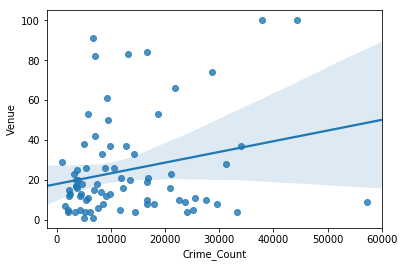

In [34]:
sns.regplot(x="Crime_Count", y="Venue", data=chicago_cleandata)

In [35]:
chicago_cleandata[["Venue","Crime_Count"]].describe()
#chicago_cleandata.corr()

Venue   Crime_Count
count   76.000000     76.000000
mean    24.907895  12835.197368
std     24.679372  11070.651656
min      1.000000    995.000000
25%      8.750000   4868.500000
50%     16.000000   8973.000000
75%     30.000000  17126.500000
max    100.000000  57211.000000

In [36]:
chicago_cleandata[["Venue","Crime_Count"]].corr()
#chicago_cleandata.corr()

Venue  Crime_Count
Venue        1.000000     0.240054
Crime_Count  0.240054     1.000000

In [37]:
from scipy import stats

In [38]:
pearson_coef, p_value = stats.pearsonr(chicago_cleandata['Crime_Count'], chicago_cleandata['Venue'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.24005437577699434  with a P-value of P = 0.036733925142372295


<h5>Conclusion:</h5>
<p>Since the p-value is $<$ 0.05, the correlation between crime rate and the number of venues is statistically significant, but the linear relationship is small (~0.24).</p>

## 9. Visualization

Let's take a closer look to the top 15 areas with highest crime rate and with the highest venue rate, respectively.

First, in order to bring the data into a similar range for comparison, we need to normalize it. This will enable us to perform a fair comparison between the different variables.

In [39]:
chicago_cleandata.head()

Area_Number  Community_Name  Venue  Crime_Count
0            1     Rogers Park     33        14284
1            2      West Ridge     37        12742
2            3          Uptown     83        13039
3            4  Lincoln Square     82         7108
4            5    North Center     38         4955

In [40]:
chicago_cleandata['Venue']= chicago_cleandata['Venue']/chicago_cleandata['Venue'].max()
chicago_cleandata['Crime_Count']= chicago_cleandata['Crime_Count']/chicago_cleandata['Crime_Count'].max()
chicago_cleandata.head()

C:\Users\TONI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\TONI\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Area_Number  Community_Name  Venue  Crime_Count
0            1     Rogers Park   0.33     0.249672
1            2      West Ridge   0.37     0.222719
2            3          Uptown   0.83     0.227911
3            4  Lincoln Square   0.82     0.124242
4            5    North Center   0.38     0.086609

In [41]:
chicago_cleandata.drop(['Area_Number'], axis=1, inplace=True)

C:\Users\TONI\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [42]:
top15_venue_areas = chicago_cleandata.nlargest(15, "Venue")
top15_crime_areas = chicago_cleandata.nlargest(15, "Crime_Count")

In [43]:
top15_venue_areas.head()

Community_Name  Venue  Crime_Count
7   Near North Side   1.00     0.776057
31             Loop   1.00     0.661097
40        Hyde Park   0.91     0.115537
6      Lincoln Park   0.84     0.290573
2            Uptown   0.83     0.227911

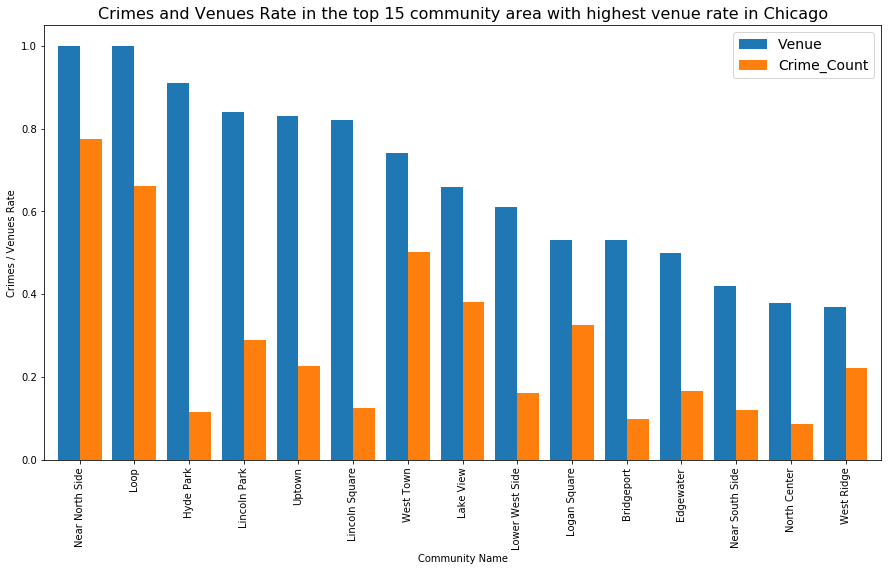

In [44]:
top15_venue_areas.set_index('Community_Name', inplace=True)

#plot data
top15_venue_areas.plot(kind='bar', figsize=(15, 8), width=0.8)

# add title to the plot
plt.ylabel('Crimes / Venues Rate')
plt.xlabel('Community Name')
plt.title('Crimes and Venues Rate in the top 15 community area with highest venue rate in Chicago', fontsize=16) 

# set legend font size
plt.legend(fontsize=14)

plt.show()

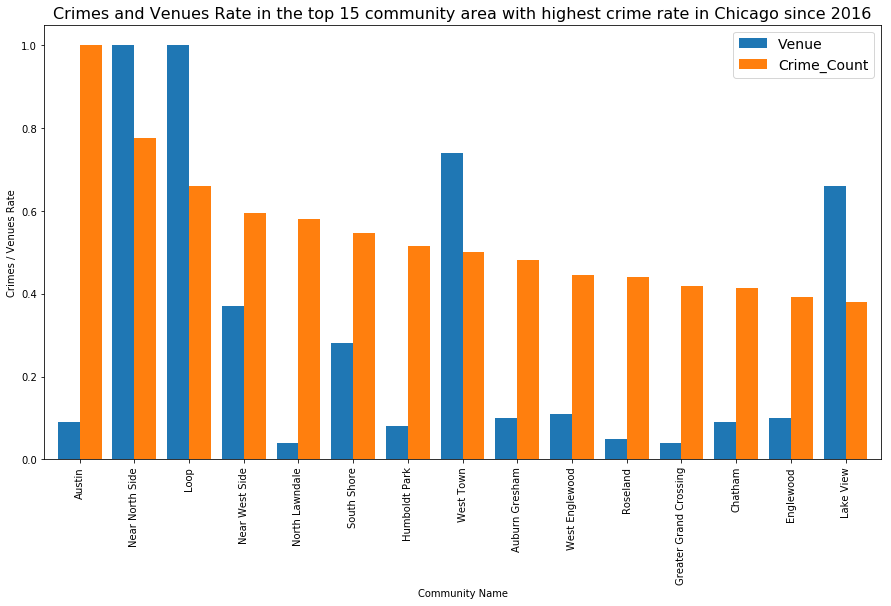

In [45]:
top15_crime_areas.set_index('Community_Name', inplace=True)

#plot data
top15_crime_areas.plot(kind='bar', figsize=(15, 8), width=0.8)

# add title to the plot
plt.ylabel('Crimes / Venues Rate')
plt.xlabel('Community Name')
plt.title('Crimes and Venues Rate in the top 15 community area with highest crime rate in Chicago since 2016', fontsize=16) 

# set legend font size
plt.legend(fontsize=14)

plt.show()    
    

In the last chart we want to visualize how distinctive the different community areas are in terms of the number of venues around.

In [46]:
chicago_venues_new = chicago_venues.groupby('Community_Name').count()
chicago_venues_new.drop(['Community_Latitude', 'Community_Longitude', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category'], axis=1, inplace=True)
chicago_venues_new.head()

Venue
Community_Name       
Albany Park        26
Archer Heights     23
Armour Square      16
Ashburn            12
Auburn Gresham     10

In [47]:
chicago_venues_new_sorted = chicago_venues_new.sort_values(by=['Venue'],ascending=False)

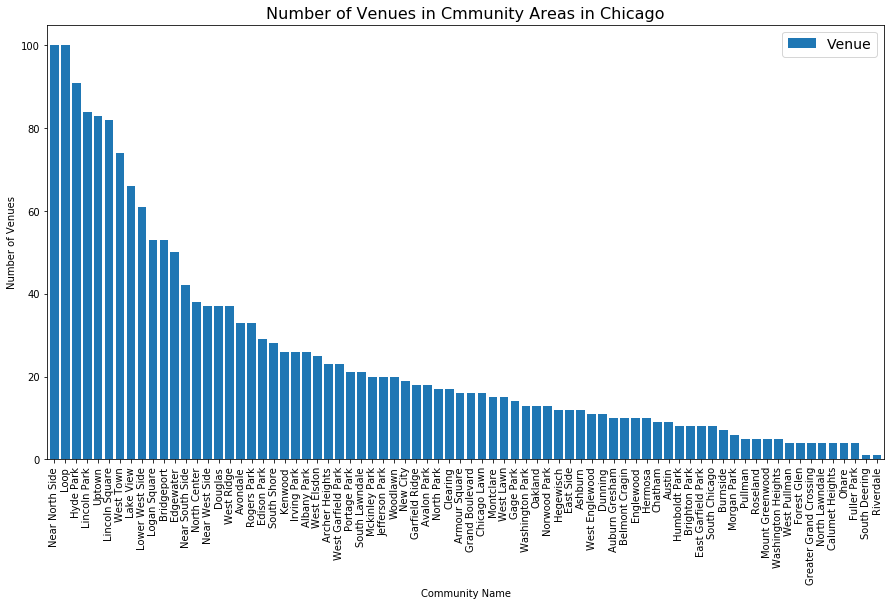

In [48]:
#chicago_venues_new.set_index('Community_Name', inplace=True)

#plot data
chicago_venues_new_sorted.plot(kind='bar', figsize=(15, 8), width=0.8)

# add title to the plot
plt.ylabel('Number of Venues')
plt.xlabel('Community Name')
plt.title('Number of Venues in Cmmunity Areas in Chicago', fontsize=16) 

# set legend font size
plt.legend(fontsize=14)

plt.show()

## 10. Conclusion

The results, shown within this research project, do not give us the liberty to assert that there is strong relationship and dependency between the crime rate and the venues in a certain geographic area. 

Although we cannot confirm to what extent these two factors shape other social and economic indicators as it was beyond the scope this project, our study suggests that their influence should not be underestimated. Additional and more in-depth research on the matter is advisable 